# Vector embedding-based change detection -- wildifre

---

In [1]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Analysis

In [50]:
embeddings_json = file_to_json('wildfire_embeddings_sz1K_2017-2023.json')
# embeddings_json = file_to_json('wildfire_embeddings_sz500_2017-2023.json')
embeddings = np.array(embeddings_json['embeddings'])
t_strs = np.array(embeddings_json['t_strs'])

In [51]:
inds_2023 = np.where([t_str.startswith('2023') for t_str in t_strs])[0]
inds_post_wf = np.where([t_str >= '2022-09-16' for t_str in t_strs])[0]
inds_pre_wf = np.where([t_str < '2022-09-16' for t_str in t_strs])[0]
embeddings_2023 = embeddings[inds_2023]
t_strs_2023 = t_strs[inds_2023]
embeddings_post_wf = embeddings[inds_post_wf]
t_strs_post_wf = t_strs[inds_post_wf]

In [52]:
from datetime import datetime

t_doy = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs])
t_doy_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_2023])
t_doy_post_wf = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_post_wf])

In [53]:
mu = embeddings.mean(axis=0)
sigma = embeddings.std(axis=0)

In [61]:
z = np.nan_to_num((embeddings - mu) / sigma)
z = np.clip(z, -6, 6)
z_2023 = z[inds_2023]

---

### Clustering

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(embeddings)

TSNE()

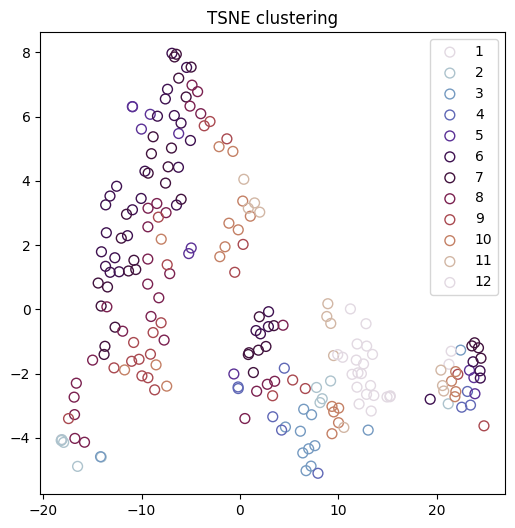

In [47]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('twilight')
for m in range(1, 12 + 1):
    m_inds = np.where([int(s.split('-')[1]) == m for s in t_strs])[0]
    tsne_emb = tsne.embedding_[m_inds]
    ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=50, ec=cmap((m - 1) / 11), fc='none', alpha=1, label=f'{m}')

ax.legend()
ax.set_title('TSNE clustering')

plt.show()

---

### Statistical model

#### PCA

In [70]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, FactorAnalysis

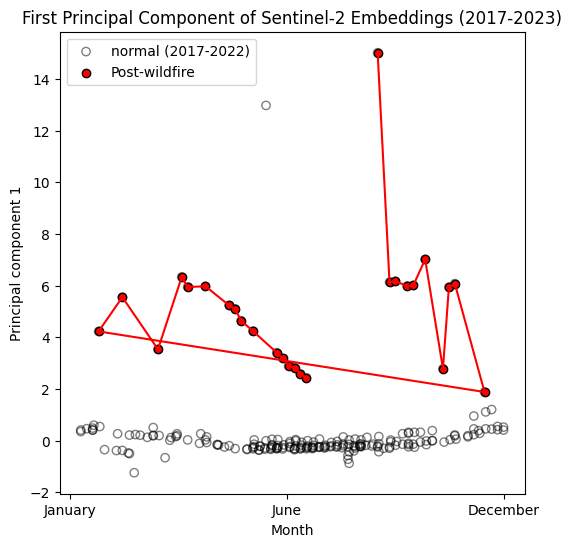

In [89]:
pca = FactorAnalysis()
pca.fit(embeddings[inds_pre_wf])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pc = 0

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

pca_emb = pca.transform(embeddings[inds_post_wf])
x = np.clip(t_doy_post_wf / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='red', label='Post-wildfire')
ax.plot(x, pca_emb[:, pc], c='r')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
# ax.set_title('Seasonal variation captured in the first principal component of Sentinel-2 embeddings')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')

plt.show()

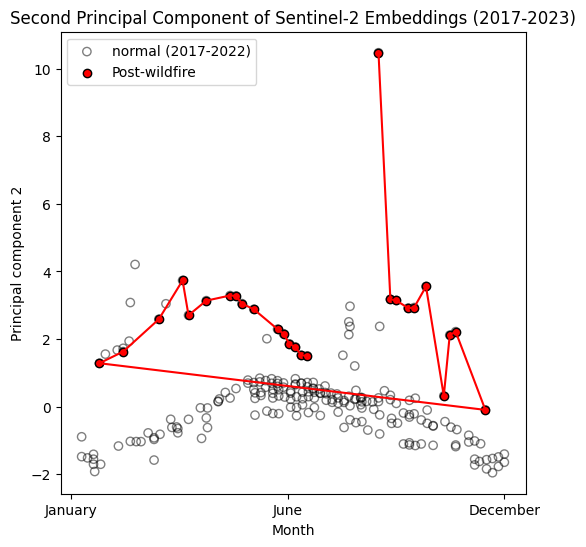

In [82]:
pca = FactorAnalysis()
pca.fit(z[inds_pre_wf])

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pc = 1

pca_emb = pca.transform(z)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

pca_emb = pca.transform(z[inds_post_wf])
x = np.clip(t_doy_post_wf / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='red', label='Post-wildfire')
ax.plot(x, pca_emb[:, pc], c='r')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [26]:
fig.savefig('embedding_seasonal_variation.png', bbox_inches='tight', pad_inches=0.2)

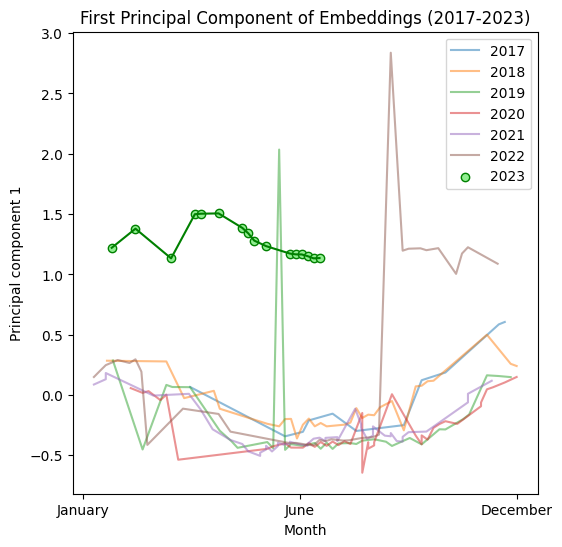

In [40]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

cmap = plt.get_cmap('tab10')
for i, year in enumerate(range(2017, 2023)):
    year_inds = np.where([t_str.startswith(str(year)) for t_str in t_strs])[0]
    pca_emb = pca.transform(embeddings[year_inds])
    x = np.clip(t_doy[year_inds] / 365, 0, 1)
    ax.plot(x, pca_emb[:, 0], c=cmap(i), alpha=0.5, label=f'{year}')


pca_emb = pca.transform(embeddings_2023)
x = np.clip(t_doy_2023 / 365, 0, 1)
ax.scatter(x, pca_emb[:, 0], ec='g', fc='lightgreen', label='2023')
ax.plot(x, pca_emb[:, 0], c='g')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')

plt.show()

---

In [57]:
def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    # feat_3 = feat_1 * feat_2
    return np.stack([feat_1, feat_2], axis=1)

In [58]:
from sklearn.linear_model import (
    LinearRegression, Ridge, BayesianRidge, HuberRegressor, RANSACRegressor,
    TheilSenRegressor, )

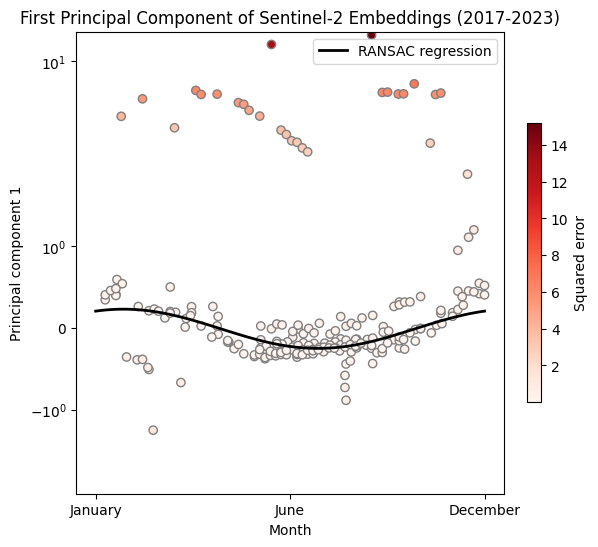

In [101]:
pca = FactorAnalysis()
pca.fit(embeddings[inds_pre_wf])
pc = 0

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Squared error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')
ax.set_yscale('symlog')
plt.show()

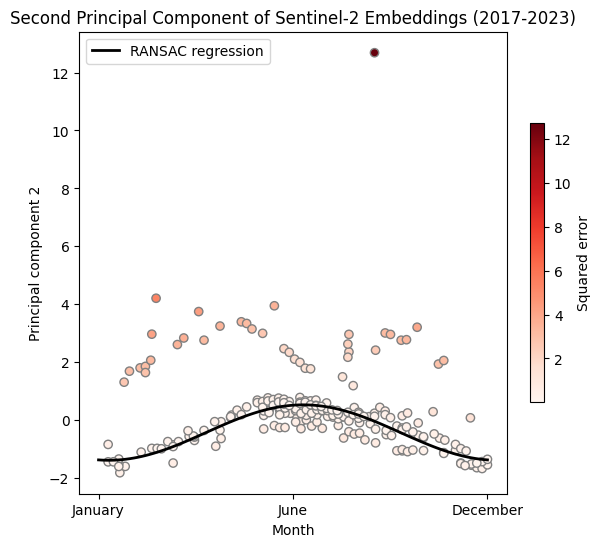

In [100]:
pca = FactorAnalysis()
pca.fit(embeddings[inds_pre_wf])
pc = 1

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Squared error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')
plt.show()